### Assignment 2

#### Submit your assignment as .ipynb

In [64]:
import math
from enum import Enum
from scipy.interpolate import CubicSpline
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import bisect

#### Exercise 1.

Implement a trinomial tree that takes the below signature:

In [65]:
class PayoffType(Enum):
    Call = 0
    Put = 1

class EuropeanOption:
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        else:
            return max(self.strike - S, 0)
    def valueAtNode(self, t, S, continuation):
        return continuation if continuation is not None else self.payoff(S)
    

class BinaryCallOption:
    def __init__(self, expiry, strike):
        self.expiry = expiry
        self.strike = strike
    def payoff(self, S):
        return 1.0 if S >= self.strike else 0.0
    def valueAtNode(self, t, S, continuation):
        return continuation if continuation is not None else self.payoff(S)


/var/folders/l3/q9v7pm6d4csg_rn4z8rtgx_00000gn/T/ipykernel_1172/393539916.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  adjusted_lam = np.log(K/S) / (vol*math.sqrt(dt)*(n - 2*closest_node))
/var/folders/l3/q9v7pm6d4csg_rn4z8rtgx_00000gn/T/ipykernel_1172/393539916.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  continuation = math.exp(-r*dt) * (vs[j]*pu + vs[j+1]*pm + vs[j+2]*pd)


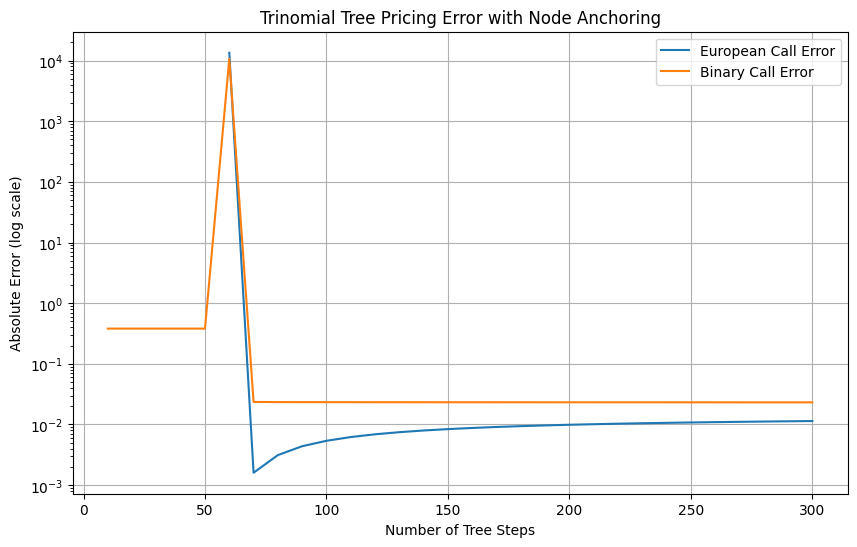

In [66]:

def trinomialPricerAnchor(S, r, q, vol, trade, n, K):
    T = trade.expiry
    dt = T / n
    
    # Initial lambda = sqrt(3)
    lam = math.sqrt(3)
    u = math.exp(lam * vol * math.sqrt(dt))
    closest_node = round((np.log(K/S) + n*lam*vol*math.sqrt(dt)) / (2*lam*vol*math.sqrt(dt)))
    adjusted_lam = np.log(K/S) / (vol*math.sqrt(dt)*(n - 2*closest_node))
    
    # Recalculate with adjusted lambda
    u = math.exp(adjusted_lam * vol * math.sqrt(dt))
    pu = 1/(2*adjusted_lam**2) + (r-q-0.5*vol**2)*math.sqrt(dt)/(2*adjusted_lam*vol)
    pd = 1/(2*adjusted_lam**2) - (r-q-0.5*vol**2)*math.sqrt(dt)/(2*adjusted_lam*vol)
    pm = 1 - pu - pd
    
    # Build tree
    vs = [trade.valueAtNode(T, S * u**(n - i), None) for i in range(2*n + 1)]
    
    for i in range(n-1, -1, -1):
        for j in range(2*i + 1):
            nodeS = S * u**(i - j)
            continuation = math.exp(-r*dt) * (vs[j]*pu + vs[j+1]*pm + vs[j+2]*pd)
            vs[j] = trade.valueAtNode(dt*i, nodeS, continuation)
    return vs[0]

def bsprice(S, r, vol, T, K, payoffType):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    if payoffType == PayoffType.Call:
        return S * cnorm(d1) - K * np.exp(-r*T) * cnorm(d2)
    else:
        return K * np.exp(-r*T) * cnorm(-d2) - S * cnorm(-d1)

def binary_bs(S, r, vol, T, K):
    d = (np.log(S/K) + (r - 0.5*vol**2)*T) / (vol*np.sqrt(T))
    return np.exp(-r*T) * cnorm(d)

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def test_anchor():
    K = 105
    S, r, vol = 100, 0.01, 0.2
    T = 1.0
    
    # Initialize trades
    euro = EuropeanOption(T, K, PayoffType.Call)
    binary = BinaryCallOption(T, K)
    
    # Benchmark prices
    bs_euro = bsprice(S, r, vol, T, K, PayoffType.Call)
    bs_binary = binary_bs(S, r, vol, T, K)
    
    # Test steps
    steps = range(10, 301, 10)
    euro_errors, binary_errors = [], []
    
    # Run tests
    for n in steps:
        euro_price = trinomialPricerAnchor(S, r, 0, vol, euro, n, K)
        binary_price = trinomialPricerAnchor(S, r, 0, vol, binary, n, K)
        euro_errors.append(abs(euro_price - bs_euro))
        binary_errors.append(abs(binary_price - bs_binary))
    
    # Plot results
    plt.figure(figsize=(10,6))
    plt.plot(steps, euro_errors, label='European Call Error')
    plt.plot(steps, binary_errors, label='Binary Call Error')
    plt.xlabel('Number of Tree Steps')
    plt.ylabel('Absolute Error (log scale)')
    plt.yscale('log')
    plt.title('Trinomial Tree Pricing Error with Node Anchoring')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    test_anchor()

Instead of taking the parameter $\lambda$ in our example code, this function takes a discontinuity K and anchors a tree node to K by tuning $\lambda$ inside the pricer.
Note that there are many ways to adjust $\lambda$, one example is to construct the tree with $\lambda = \sqrt{3}$ first, find the node closest to $K$, then adjust $\lambda$ such that the node falls on $K$, but you are free to define your own way to achieve this.

Plot the pricing errors of this trinomial tree pricer with the market and strike below, for number of tree steps from 10 to 300 (similar to our binomial tree test cases).
Use a European Call option and a Binary Call option as test trades.

In [67]:
# K = 105
# S, r, vol = 100, 0.01, 0.2

#### Exercise 2.

Assuming forward delta convention, implement below function ```strikeFromdelta``` that calculates the strike from a given delta.
You may use the ```fwdDelta``` function below. Test with below:

S, r, q, T, vol, delta, payoffType = 100, 0.1, 0, 1, 0.1, 0.25, PayoffType.Put

In [68]:
class PayoffType(Enum):
    Call = 0
    Put = 1

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta, assuming forward delta convention
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S * math.exp((r - q) * T)
    stdev = vol * math.sqrt(T)
    
    # Adjust delta sign for Put option (delta should be negative for Put in forward convention)
    if payoffType == PayoffType.Put:
        target_delta = -delta
    else:
        target_delta = delta
    
    # Define the equation to solve: fwdDelta - target_delta = 0
    def equation(K):
        return fwdDelta(fwd, stdev, K, payoffType) - target_delta
    
    
    # Brent's method requires a bracketing interval
    a = 0.0001  # Minimal strike
    b = fwd * 10  # Maximal strike (adjusted dynamically if needed)
    
    # Use Brent's method to solve for K
    strike = optimize.brentq(equation, a, b, xtol=1e-6)
    return strike

# Test case
S, r, q, T, vol, delta, payoffType = 100, 0.1, 0, 1, 0.1, 0.25, PayoffType.Put
K = strikeFromDelta(S, r, q, T, vol, delta, payoffType)
print(f"The Strike price is : {K:.10f}")



The Strike price is : 103.8264973182


#### Exercise 3.

Implement ```smilefromMarks``` function below, it take the time to maturity $T$, current stop price $S$, risk free and dividend rate $r$ and $q$,
ATM volatility, BF25, RR25, BF10, RR10 quotes, returns a CubicSpline interpolated smile for this pillar. We assume ATM forward convention. 
You may use the Smile class provided below.   

In [69]:
class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes  + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    # Define moneyness levels
    deltas = np.array([0.10, 0.25, 0.50, 0.75, 0.90])
    forwards = S * np.exp((r - q) * T)  # Forward price calculation
    
    # Compute strikes from deltas assuming Black-Scholes model
    strikes = forwards * np.exp(-np.sqrt(T) * atmvol * np.array([-rr10/2 - bf10, -rr25/2 - bf25, 0, rr25/2 + bf25, rr10/2 + bf10]))
    
    # Define volatilities at strikes
    vols = np.array([atmvol + bf10 + rr10/2, atmvol + bf25 + rr25/2, atmvol, atmvol + bf25 - rr25/2, atmvol + bf10 - rr10/2])
    
    # Ensure strikes are sorted in ascending order
    sorted_indices = np.argsort(strikes)
    strikes = strikes[sorted_indices].tolist()
    vols = vols[sorted_indices].tolist()
    return Smile(strikes, vols)

With ```smileFromMarks```, we can prepare our implied volatility surface from input marks.

In [70]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

Plot the test implied volatility surface using below test functions.

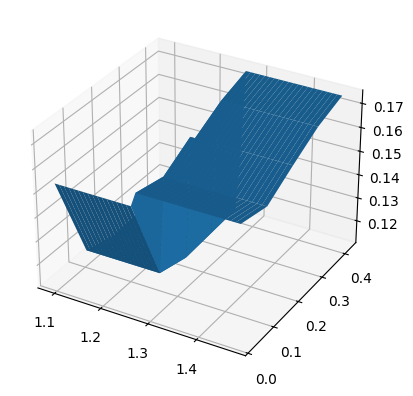

In [71]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    plt.show()
plotTestImpliedVolSurface()